# The BESS optimisation problem (including FCAS)

Refer to the [optimiser](./optimiser.ipynb) notebook first for the basic derivation of this problem.

Adding FCAS requires a slight change to the problem formulation. The main thing to mention is that the main variable becomes a (horizon, actions) array, where there are 8 possible actions,

* 0, how much to charge by
* 1, how much to discharge by
* 2, how much to assign to the raise 6 second market
* 3, how much to assign to the raise 60 second market
* 4, how much to assign to the raise 5 minute market
* 5, how much to assign to the lower 6 second market
* 6, how much to assign to the lower 60 second market
* 7, how much to assign to the lower 5 minute market

The optimisation still feels largely unfinished, I think I still need to spend some time fixing how frequency response events are modelled, etc. For now though the model makes good money compared to benchmark strategies (and notably, more money than the basic energy optimiser). There's also quite a bit of work to do in speeding the optimisation/backtests up.

I've made A LOT of assumptions in these backtests and models. I'll try to name a few of them here, and how that affects the modelling.

#### Assumption 1 - Frequency response events

I wasn't really sure how to do this cleanly, and it's funny because the optimiser operates differently to the backtests. In each, we assign probabilities (a flat 5% is what I ran with) against each FCAS market requiring us to take action each interval. In the backtests, these are modelled as events, and have an impact on the SOC. In this optimiser, this is treated like an expected value, and simply multiplied through to the SOC.

Ideally, I'd do some proper research and figure out how often frequency response services are required. This would enable me to a) give proper estimates of the probabilities in the optimisation, and b) give proper counts on the number of response events required per market in the backtest. For now this simply didn't feel like a hard requirement.


#### Assumption 2 - Bidding

This is straightforward - the way the backtests and optimisers work at the moment, if we want to take part in a market, we just assume we can, and we assume we have zero price impact. This is total rubbish, and not reflective of what it would actually be like to operate.

I think more time would need to be put into looking at price impact, and potentially even probabilities against each FCAS market that dictate whether you're chosen to provide FCAS services in each particular time interval.


#### Assumption 3 - Efficiencies

I wasn't actually sure what to do about this. If we promise to provide 50MW to the raise 6 second FCAS market, but we have a 90% discharge efficiency, on a 50MW battery, does that mean we're unable to actually fulfil our obligation? This is something I need to look more into, at the moment efficiencies are only accounted for in the SOC after the fact.

In [1]:
import cvxpy as cp
import numpy


TOLERANCE = 1e-4

# Aligned to action vector indices [charge, discharge, R6SEC, R60SEC, R5MIN, L6SEC, L60SEC, L5MIN]
# Probability that each market is dispatched in a given 5-min interval
_EVENT_PROBS = numpy.array(
    [
        1.0,
        1.0,
        0.05,
        0.05,
        0.05,
        0.05,
        0.05,
        0.05,
    ]
)

# Duration of full response (hours) for each action type
_DURATIONS = numpy.array(
    [
        5 / 60,
        5 / 60,
        6 / 3600,
        60 / 3600,
        5 / 60,
        6 / 3600,
        60 / 3600,
        5 / 60,
    ]
)

# Charge-side action indices: [charge, L6SEC, L60SEC, L5MIN]
_CHG_IDX = [0, 5, 6, 7]
# Discharge-side action indices: [discharge, R6SEC, R60SEC, R5MIN]
_DCHG_IDX = [1, 2, 3, 4]

# Weights for expected SOC change (per MW of action) for each side.
# delta_c = eta_chg * (p[:,_CHG_IDX] @ _CHG_WEIGHTS) - eta_dchg * (p[:,_DCHG_IDX] @ _DCHG_WEIGHTS)
_CHG_WEIGHTS = (_EVENT_PROBS * _DURATIONS)[
    _CHG_IDX
]  # [dt, 0.05*6/3600, 0.05*60/3600, 0.05*dt]
_DCHG_WEIGHTS = (_EVENT_PROBS * _DURATIONS)[
    _DCHG_IDX
]  # [dt, 0.05*6/3600, 0.05*60/3600, 0.05*dt]


gamma = 0
horizon = 12 * 24
dt = 5 / 60

forecast = cp.Parameter((7, horizon), name="forecast")
c_initial = cp.Parameter(name="c_initial")
p_max = cp.Parameter(name="p_max")
c_max = cp.Parameter(name="c_max")
eta_chg = cp.Parameter(name="eta_chg")
eta_dchg = cp.Parameter(name="eta_dchg")

x = cp.Variable((horizon, 8), nonneg=True, name="x")

energy_revenue = dt * cp.sum(cp.multiply(forecast[0, :], x[:, 1] - x[:, 0]))
fcas_revenue = dt * cp.sum(cp.multiply(forecast[1:, :].T, x[:, 2:]))
penalty = dt * gamma * cp.sum(x)

objective = cp.Minimize(-energy_revenue - fcas_revenue + penalty)

delta_c = eta_chg * (x[:, _CHG_IDX] @ _CHG_WEIGHTS) - eta_dchg * (
    x[:, _DCHG_IDX] @ _DCHG_WEIGHTS
)
c_soc = c_initial + dt * cp.cumsum(delta_c)

constraints = [
    # SOC bounds
    c_soc >= 0,
    c_soc <= c_max,
    # Discharge-side power pool: discharge + raise FCAS share p_max
    x[:, 1] + x[:, 2] + x[:, 3] + x[:, 4] <= p_max,
    # Charge-side power pool: charge + lower FCAS share p_max
    x[:, 0] + x[:, 5] + x[:, 6] + x[:, 7] <= p_max,
]

problem = cp.Problem(objective=objective, constraints=constraints)

In [2]:
import pandas

from bessie.backtests import BacktestInputData
from bessie.core import Region
from bessie.plotting import tsplot


start = pandas.Timestamp("2022-01-01 00:00:00")
end = pandas.Timestamp("2022-02-01 00:00:00")

data = BacktestInputData.from_aemo_forecasts(
    start=start,
    end=end,
    region=Region.NSW,
)

2026-02-25 12:31:16,122 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=1.netcdf
2026-02-25 12:31:16,405 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=2.netcdf
2026-02-25 12:31:16,448 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=1.netcdf
2026-02-25 12:31:16,465 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=2.netcdf
2026-02-25 12:31:16,769 - INFO - root - nemosis query start: 2022/01/01 00:00:00
2026-02-25 12:31:16,769 - INFO - root - nemosis query end: 2022/02/01 00:00:00
2026-02-25 12:31:16,770 - INFO - nemosis.data_fetch_methods - Compiling data for table DISPATCHPRICE
2026-02-25 12:31:17,200 - INFO - nemosis.data_fetch_methods - Returning DISPATCHPRICE.


In [3]:
problem.param_dict["forecast"].value = data.forecast[0, :, :horizon]
problem.param_dict["c_initial"].value = 0.0
problem.param_dict["p_max"].value = 50
problem.param_dict["c_max"].value = 50
problem.param_dict["eta_chg"].value = 0.90
problem.param_dict["eta_dchg"].value = 0.95

problem.solve(solver=cp.CLARABEL, verbose=True)

(CVXPY) Feb 25 12:31:17 PM: Your problem has 2304 variables, 1152 constraints, and 2021 parameters.
(CVXPY) Feb 25 12:31:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 25 12:31:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 25 12:31:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 25 12:31:17 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Feb 25 12:31:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Feb 25 12:31:17 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 25 12:31:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 25 12:31:17 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 25 12:31:17 PM: Applying reduction CLARABEL
(CVXPY) Feb 25 12:31:17 PM: Finished problem compilation (took 1.050e-01 seconds).
(CVXPY) Feb 25 12:31:17 PM: (Subsequent compilations of this problem, using the same arguments,

                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 2880
  constraint

(CVXPY) Feb 25 12:31:17 PM: Problem status: optimal
(CVXPY) Feb 25 12:31:17 PM: Optimal value: -6.109e+04
(CVXPY) Feb 25 12:31:17 PM: Compilation took 1.050e-01 seconds
(CVXPY) Feb 25 12:31:17 PM: Solver (including time spent in interface) took 5.138e-02 seconds


  0  +2.7652e+04  -2.0313e+06  7.45e+01  6.36e-01  2.35e-02  1.00e+00  3.18e+03   ------   
  1  -8.9261e+04  -4.1708e+05  3.67e+00  2.17e-01  4.64e-03  3.08e+02  7.97e+02  9.02e-01  
  2  -7.1201e+04  -2.2446e+05  2.15e+00  1.28e-01  2.49e-03  1.47e+02  4.83e+02  4.33e-01  
  3  -6.2145e+04  -1.3138e+05  1.11e+00  7.28e-02  1.33e-03  6.45e+01  2.70e+02  5.16e-01  
  4  -5.8891e+04  -9.3934e+04  5.95e-01  4.43e-02  7.60e-04  3.19e+01  1.55e+02  7.28e-01  
  5  -5.8659e+04  -7.1704e+04  2.22e-01  1.79e-02  2.95e-04  1.12e+01  6.27e+01  7.14e-01  
  6  -6.0015e+04  -6.4823e+04  8.01e-02  6.82e-03  1.14e-04  3.64e+00  2.37e+01  7.67e-01  
  7  -6.0421e+04  -6.3005e+04  4.28e-02  3.65e-03  6.15e-05  1.82e+00  1.28e+01  5.73e-01  
  8  -6.0715e+04  -6.1956e+04  2.04e-02  1.72e-03  2.91e-05  7.64e-01  6.19e+00  7.17e-01  
  9  -6.0928e+04  -6.1421e+04  8.10e-03  6.82e-04  1.16e-05  2.82e-01  2.47e+00  7.35e-01  
 10  -6.0929e+04  -6.1402e+04  7.77e-03  6.54e-04  1.11e-05  2.66e-01  2.37e+00 

np.float64(-61085.52974753812)

2026-02-25 12:31:17,618 - INFO - choreographer.browsers.chromium - Chromium init'ed with kwargs {}
2026-02-25 12:31:17,619 - INFO - choreographer.browsers.chromium - Found chromium path: /app/.venv/lib/python3.12/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
2026-02-25 12:31:17,619 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmp_0h64f49.
2026-02-25 12:31:17,620 - INFO - choreographer.browser_async - Opening browser.
2026-02-25 12:31:17,621 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmpkaq48pxk.
2026-02-25 12:31:17,640 - INFO - choreographer.browsers.chromium - Temporary directory at: /tmp/tmpkaq48pxk
2026-02-25 12:31:17,915 - INFO - kaleido.kaleido - Conforming 1 to file:///tmp/tmp_0h64f49/index.html
2026-02-25 12:31:17,916 - INFO - kaleido.kaleido - Waiting on all navigates
2026-02-25 12:31:19,690 - INFO - kaleido.kaleido - All navigates done, putting them all in queue.
2026-02-25 12:31:19,691 - INFO - kaleido.kale

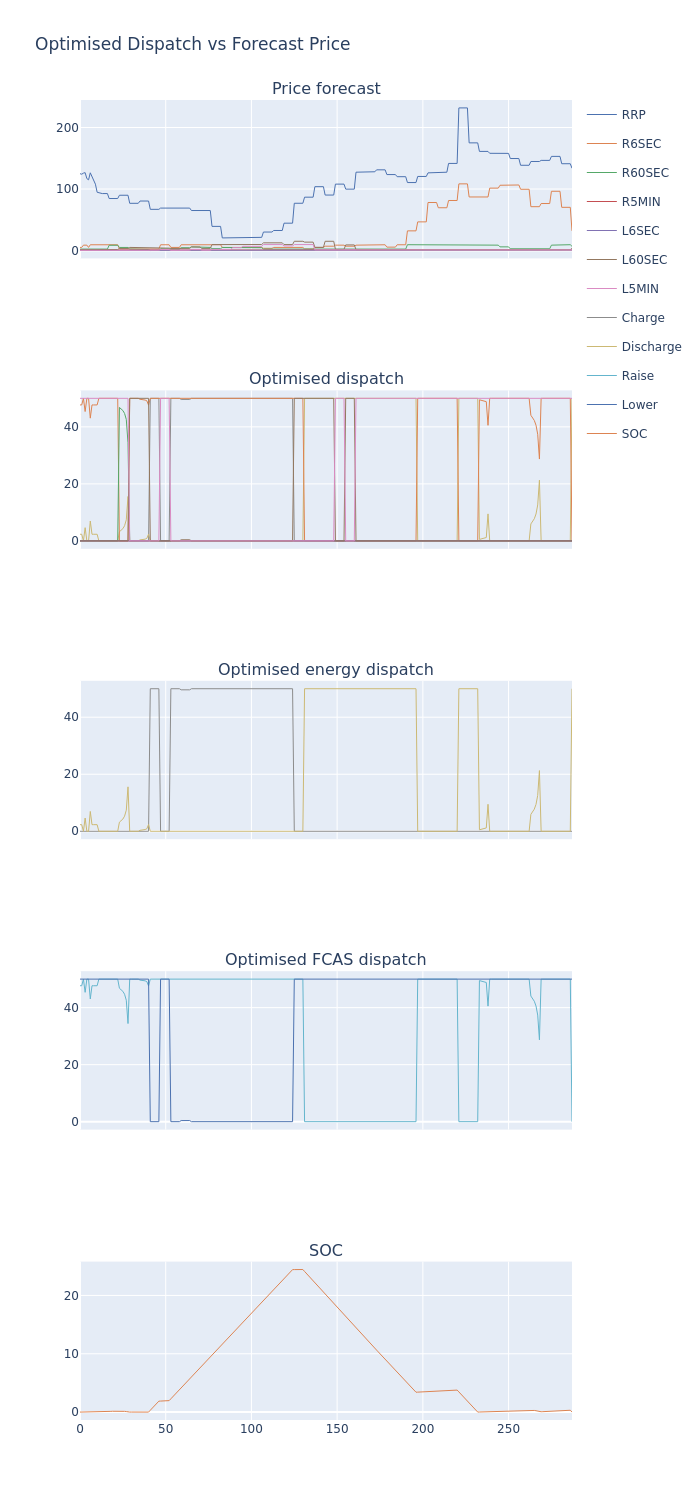

In [4]:
columns = [
    "RRP",
    "R6SEC",
    "R60SEC",
    "R5MIN",
    "L6SEC",
    "L60SEC",
    "L5MIN",
]

tsplot(
    {
        "Price forecast": pandas.DataFrame(
            data.forecast[0, :, :horizon].T, columns=columns
        ),
        "Optimised dispatch": pandas.DataFrame(
            problem.var_dict["x"].value,
            columns=["Charge", "Discharge"] + columns[1:],
        ),
        "Optimised energy dispatch": pandas.DataFrame(
            problem.var_dict["x"].value[:, :2], columns=["Charge", "Discharge"]
        ),
        "Optimised FCAS dispatch": pandas.DataFrame(
            {
                "Raise": problem.var_dict["x"].value[:, 2:5].sum(axis=1),
                "Lower": problem.var_dict["x"].value[:, 5:8].sum(axis=1),
            }
        ),
        "SOC": pandas.DataFrame(c_soc.value, columns=["SOC"]),
    },
    title="Optimised Dispatch vs Forecast Price",
    resampler=False,
).show("png")


2026-02-25 12:31:20,219 - INFO - choreographer.browsers.chromium - Chromium init'ed with kwargs {}
2026-02-25 12:31:20,221 - INFO - choreographer.browsers.chromium - Found chromium path: /app/.venv/lib/python3.12/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
2026-02-25 12:31:20,222 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmplsc_5cdg.
2026-02-25 12:31:20,222 - INFO - choreographer.browser_async - Opening browser.
2026-02-25 12:31:20,224 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmpld9v2rv6.
2026-02-25 12:31:20,239 - INFO - choreographer.browsers.chromium - Temporary directory at: /tmp/tmpld9v2rv6
2026-02-25 12:31:20,473 - INFO - kaleido.kaleido - Conforming 1 to file:///tmp/tmplsc_5cdg/index.html
2026-02-25 12:31:20,475 - INFO - kaleido.kaleido - Waiting on all navigates
2026-02-25 12:31:21,689 - INFO - kaleido.kaleido - All navigates done, putting them all in queue.
2026-02-25 12:31:21,690 - INFO - kaleido.kale

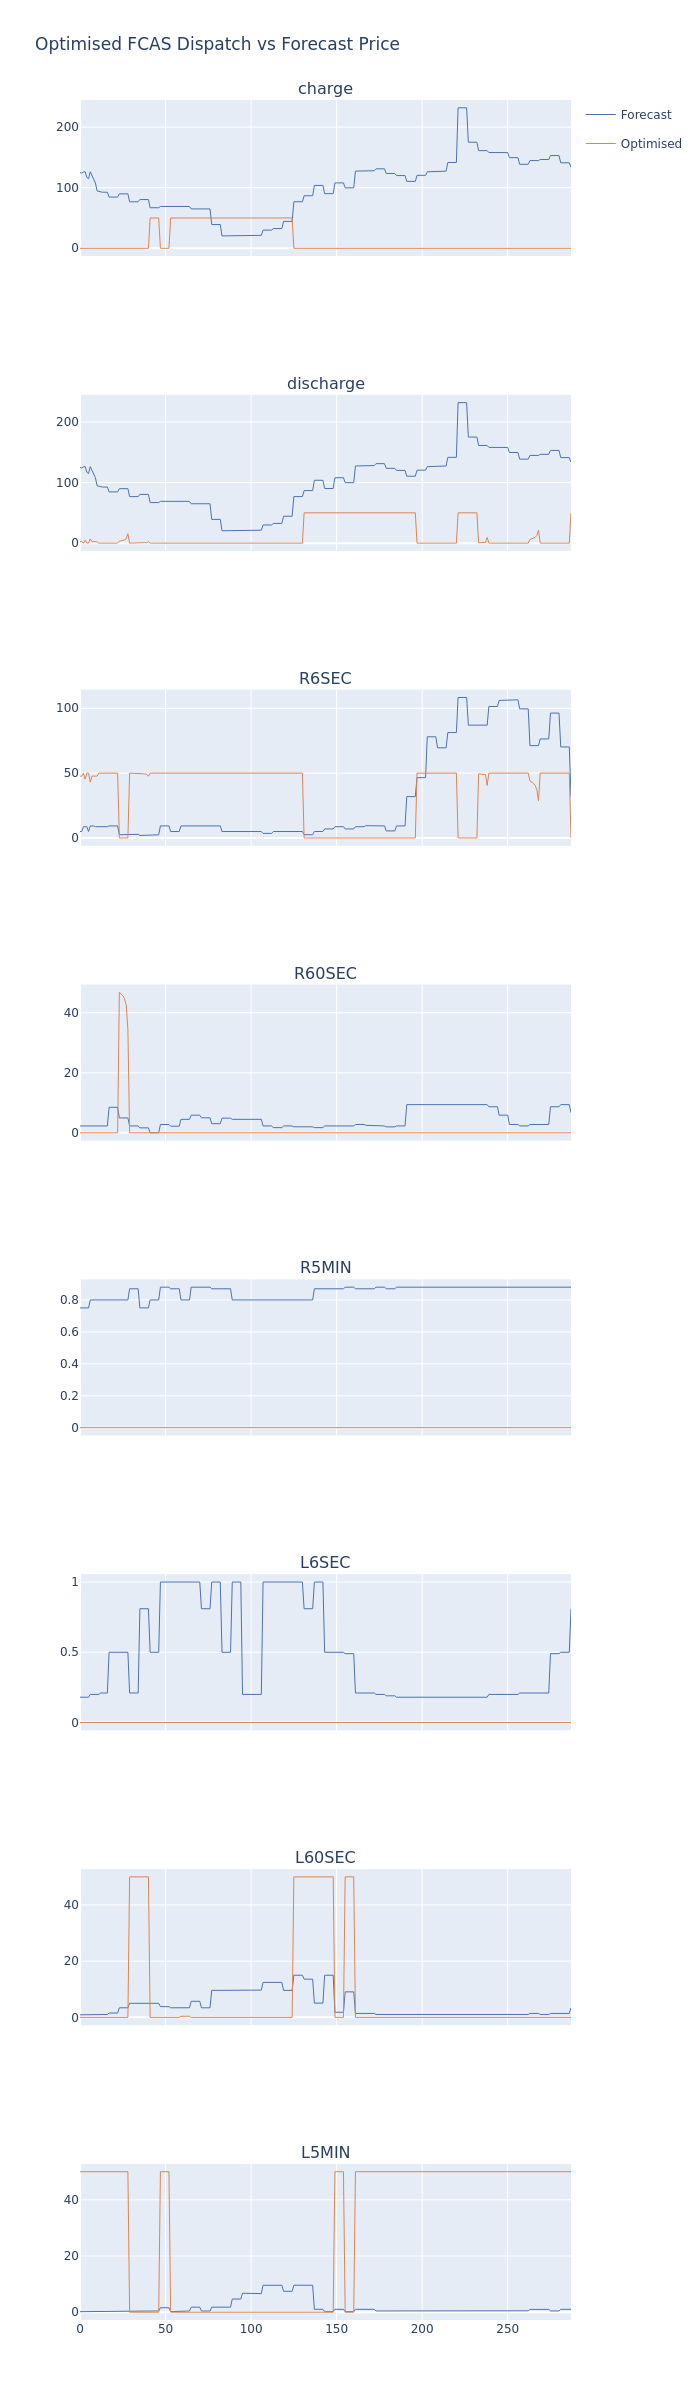

In [5]:
columns = [
    (0, "charge"),
    (0, "discharge"),
    (1, "R6SEC"),
    (2, "R60SEC"),
    (3, "R5MIN"),
    (4, "L6SEC"),
    (5, "L60SEC"),
    (6, "L5MIN"),
]

tsplot(
    {
        col: pandas.DataFrame(
            {
                "Forecast": data.forecast[0, i, :horizon],
                "Optimised": problem.var_dict["x"].value[:, idx],
            }
        )
        for idx, (i, col) in enumerate(columns)
    },
    title="Optimised FCAS Dispatch vs Forecast Price",
    resampler=False,
).show("png")